In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install soundfile librosa numpy pyroomacoustics matplotlib tqdm torch torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 81.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.8.6-cp312-cp312-linux_x86_64.whl size=47010321 sha256=75236cfa810b747532cd79c24362d6b1086ce3ce477a08c9b7623cf47dd762f6
  Stored in directory: /root/.cache/pip/wheels/41/d8/86/0969204fd58c781705094db3a180e34219d82a52d5c0f5e6ac
Successfully built pyroomacoustics


In [ ]:
import soundfile as sf
import librosa
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from dataclasses import dataclass

%matplotlib inline

In [ ]:
N_FTT = 512
HOP=128
WIN=512
WINDOW="blackman"
EPS=1e-10
COUNT_OF_FILES = 1000

In [ ]:
from utils import download_dataset
download_dataset()

nonblind_test.clean.zip: 100%|██████████| 251M/251M [00:04<00:00, 59.1MB/s]

Файл успешно скачан: nonblind_test.clean.zip


In [ ]:
path_diffusion = Path("./diffusion")
path_diffusion.mkdir(exist_ok=True)

path_reverbed = Path("./diffusion/reverbed")
path_reverbed.mkdir(exist_ok=True)

path_wpe = Path("./diffusion/wpe")
path_wpe.mkdir(exist_ok=True)

path_output = Path("./diffusion/output")
path_output.mkdir(exist_ok=True)
print("Созданы директории:diffusion/reverbed, diffusion/output, diffusion/wpe")

Созданы директории:diffusion/reverbed, diffusion/output, diffusion/wpe


In [ ]:
current_dir = Path(".")
data = Path("nonblind_test.clean.zip")
with zipfile.ZipFile(data, "r") as zip_ref:
    zip_ref.extractall(current_dir)
print("Архив успешно разархивирован в clean")

Архив успешно разархивирован в clean


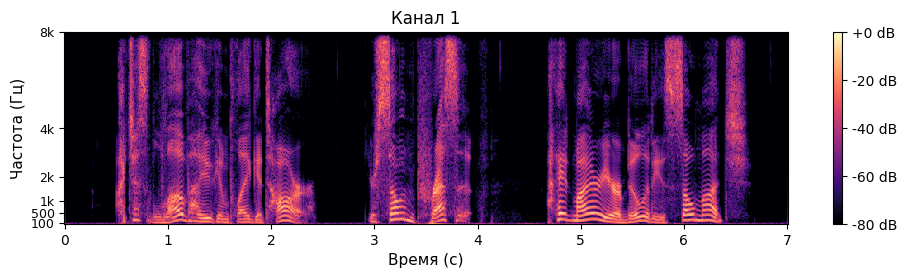

In [ ]:
from utils import read_normalize, plot_audio_spectrogram
y_clean, sr = read_normalize("clean/fileid_1.flac")
plot_audio_spectrogram(y_clean, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW)

In [ ]:
def reverb_audio_mono(y_clean, sr, plot=False):
    room_dim = [6.0, 4.0, 3]
    rt60 = 0.8

    absorption, max_order = pra.inverse_sabine(rt60, room_dim)

    room = pra.ShoeBox(
        room_dim, fs=sr,
        materials=pra.Material(absorption),
        max_order=max_order
    )

    src_pos = [5.0, 4, 1.7]
    mic_pos = [2.5, 2, 1.6]

    if plot:
        fig, ax = room.plot(img_order=0, figsize=(8, 5))
        ax.scatter(src_pos[0], src_pos[1], src_pos[2],
                   color='red', s=400, marker='*')
        ax.scatter(mic_pos[0], mic_pos[1], mic_pos[2],
               color='blue', s=200, marker='^')
        plt.title("Виртуальная комната")
        return None


    room.add_source(src_pos, signal=y_clean)

    mic = pra.MicrophoneArray(np.c_[mic_pos], room.fs)
    room.add_microphone_array(mic)

    room.simulate()
    reverbed = room.mic_array.signals[0]

    if len(reverbed) > len(y_clean):
        reverbed = reverbed[:len(y_clean)]

    return reverbed

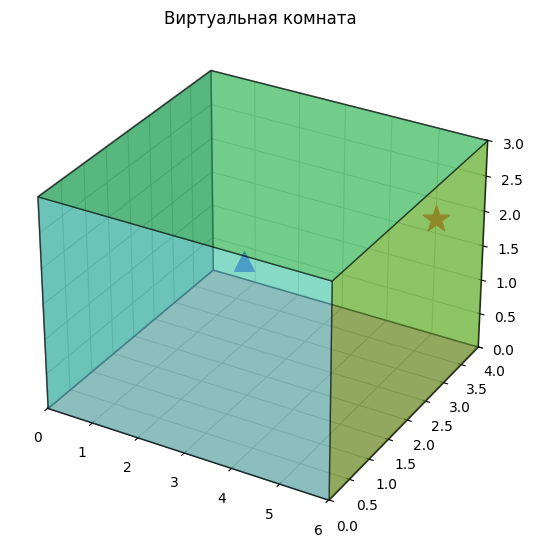

In [ ]:
reverb_audio_mono(y_clean=y_clean, sr=sr, plot=True)

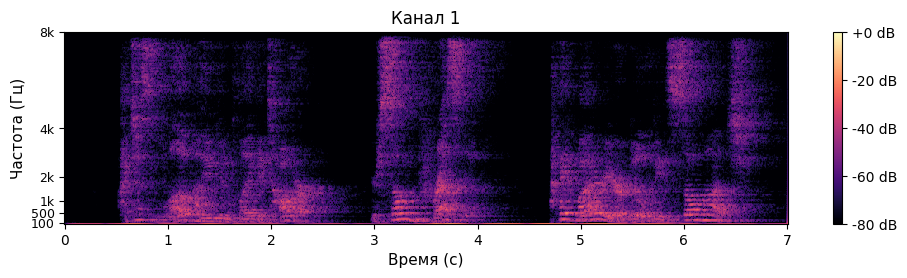

In [ ]:
y_reverbed = reverb_audio_mono(y_clean, sr)
plot_audio_spectrogram(y_reverbed, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW)

In [ ]:
def wpe_mono(
    y, sr,
    n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW, eps=EPS,
    D=3, L=10, N=3, reg=1e-6
):
    Y = librosa.stft(y, n_fft=n_fft, hop_length=hop, win_length=win, window=window)
    F, T = Y.shape

    P = np.abs(Y) ** 2
    kernel = np.ones(L, dtype=P.dtype) / L
    P_smooth = np.stack([np.convolve(P[f], kernel, mode='same') for f in range(F)])
    lam = np.maximum(P_smooth, eps)

    Z = np.copy(Y)

    for n in range(N):
        for f in range(F):
            t_idx = np.arange(D + L, T)
            Te = t_idx.size

            YL = np.vstack([Y[f, t_idx - D - k] for k in range(1, L + 1)])

            y_t = Y[f, t_idx]
            w = 1.0 / (lam[f, t_idx] ** 2)

            Phi = (YL * w) @ YL.conj().T
            Phi += reg * np.eye(L)

            phi = (YL * w) @ y_t.conj()

            g = np.linalg.solve(Phi, phi)

            Z_f = np.copy(Y[f])
            Z_f[t_idx] = y_t - g.conj().T @ YL
            Z[f] = Z_f

            Pz = np.abs(Z_f) ** 2
            lam[f] = np.maximum(np.convolve(Pz, kernel, mode='same'), eps)

    z = librosa.istft(Z, hop_length=hop, win_length=win, window=window, length=len(y))
    return z


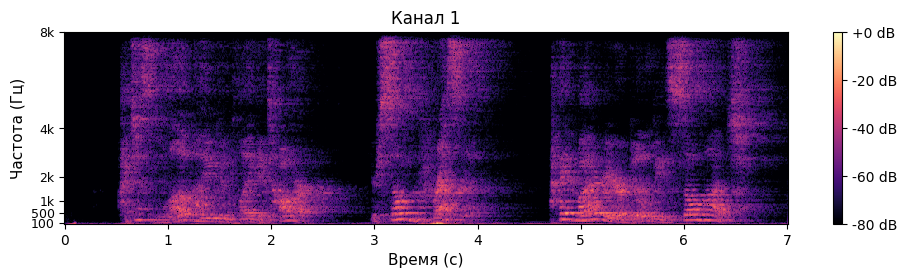

In [ ]:
y_wpe = wpe_mono(y_reverbed, sr)
plot_audio_spectrogram(y_wpe, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW)

## Создаём датасет

In [ ]:
path_clean = Path("clean")

In [ ]:
path_clean = Path("clean")
clean_audio = [f for f in path_clean.iterdir() if f.is_file()]

for file in clean_audio:
    break
    y_clean, sr = read_normalize(path_clean / file.name)
    y_reverbed = reverb_audio_mono(y_clean, sr)
    y_wpe = wpe_mono(y_reverbed, sr)
    sf.write(path_reverbed / file.name, y_reverbed, sr)
    sf.write(path_wpe / file.name, y_wpe, sr)

In [ ]:
current_dir = Path("./diffusion/")
data = Path("/content/drive/MyDrive/Dereverberation/wpe.zip")

with zipfile.ZipFile(data, "r") as zip_ref:
    zip_ref.extractall(current_dir)

data = Path("/content/drive/MyDrive/Dereverberation/reverbed.zip")

with zipfile.ZipFile(data, "r") as zip_ref:
    zip_ref.extractall(current_dir)

In [ ]:
import torch
import random
import math
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm.auto import tqdm

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

REV_DIR = Path("./diffusion/wpe").resolve()
CLEAN_DIR = Path("./clean").resolve()
OUT_DIR = Path("./out_dereverb").resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

SR = 16000
FRAMES = 256

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED);
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

T = 1000
BETA_START = 1e-4
BETA_END = 2e-2

print("Data roots:", REV_DIR, CLEAN_DIR)

DEVICE: cuda
Data roots: /content/diffusion/wpe /content/clean


In [ ]:
def stft_complex(y):
    return librosa.stft(y, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW, center=True)

def istft_from_mag_phase(mag, phase, length=None):
    S = mag * np.exp(1j * phase)
    return librosa.istft(S, hop_length=HOP, win_length=WIN, window=WINDOW, length=length)

def log_mag_from_complex(S):
    return np.log(np.abs(S) + EPS)

def pad_or_crop_frames(img, target_frames):
    F, T = img.shape
    if T == target_frames: return img
    if T > target_frames:  return img[:, :target_frames]
    pad = target_frames - T
    return np.concatenate([img, np.full((F, pad), img.min(), dtype=img.dtype)], axis=1)

class PairSpecDataset(Dataset):
    def __init__(self, rev_dir, clean_dir, frames=FRAMES, limit=COUNT_OF_FILES):
        self.rev_dir = Path(rev_dir)
        self.clean_dir = Path(clean_dir)
        self.frames = frames
        rev_names = {p.stem for p in sorted(self.rev_dir.glob("*.flac"))}
        clean_names = {p.stem for p in sorted(self.clean_dir.glob("*.flac"))}
        names = sorted(list(rev_names & clean_names))
        if limit is not None:
            names = names[:limit]
        self.items = [(self.rev_dir/f"{n}.flac", self.clean_dir/f"{n}.flac") for n in names]

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        rev_path, clean_path = self.items[idx]
        rev_y, sr1 = read_normalize(str(rev_path))
        clean_y, sr2 = read_normalize(str(clean_path))
        assert sr1 == sr2 == SR

        if rev_y.ndim != 1:
            rev_y = rev_y.reshape(-1)
        if clean_y.ndim != 1:
            clean_y = clean_y.reshape(-1)

        L = min(len(rev_y), len(clean_y))
        if L == 0:
            L = WIN
            rev_y = np.zeros(L, dtype=np.float32)
            clean_y = np.zeros(L, dtype=np.float32)
        else:
            rev_y, clean_y = rev_y[:L].astype(np.float32), clean_y[:L].astype(np.float32)

        if len(rev_y) < WIN:
            rev_y = np.pad(rev_y, (0, WIN - len(rev_y)))
        if len(clean_y) < WIN:
            clean_y = np.pad(clean_y, (0, WIN - len(clean_y)))

        rev_y = np.nan_to_num(rev_y, nan=0.0, posinf=0.0, neginf=0.0)
        clean_y = np.nan_to_num(clean_y, nan=0.0, posinf=0.0, neginf=0.0)

        rev_S = stft_complex(rev_y)
        clean_S = stft_complex(clean_y)

        rev_img = np.nan_to_num(log_mag_from_complex(rev_S), nan=0.0, posinf=0.0, neginf=0.0)
        clean_img = np.nan_to_num(log_mag_from_complex(clean_S), nan=0.0, posinf=0.0, neginf=0.0)

        mu = float(rev_img.mean())
        std = float(rev_img.std())
        if std < 1e-6:
            std = 1e-6

        rev_img_n = (np.clip(rev_img, -20, 20) - mu) / std
        clean_img_n = (np.clip(clean_img, -20, 20) - mu) / std

        rev_img_n = np.nan_to_num(rev_img_n, nan=0.0, posinf=0.0, neginf=0.0)
        clean_img_n = np.nan_to_num(clean_img_n, nan=0.0, posinf=0.0, neginf=0.0)

        rev_img_n = pad_or_crop_frames(rev_img_n, self.frames)
        clean_img_n = pad_or_crop_frames(clean_img_n, self.frames)

        rev_phase = np.angle(rev_S)[:, :self.frames]
        rev_t = torch.tensor(rev_img_n, dtype=torch.float32).unsqueeze(0)
        clean_t = torch.tensor(clean_img_n, dtype=torch.float32).unsqueeze(0)

        return {
            "rev_img": rev_t,
            "clean_img": clean_t,
            "rev_phase": torch.tensor(rev_phase, dtype=torch.float32),
            "length": torch.tensor([L], dtype=torch.long),
        }


full_ds = PairSpecDataset(REV_DIR, CLEAN_DIR, frames=FRAMES, limit=COUNT_OF_FILES)
n = len(full_ds)

idx = list(range(n))
random.shuffle(idx)
split = int(0.9 * n) if n > 1 else n

from torch.utils.data import Subset

train_ds = Subset(full_ds, idx[:split]) if split > 0 else full_ds
val_ds   = Subset(full_ds, idx[split:]) if split < n else full_ds

BATCH_SIZE = 8
pin = torch.cuda.is_available()
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          drop_last=True, num_workers=0, pin_memory=pin)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          drop_last=False, num_workers=0, pin_memory=pin)


print(f"Всего пар: {len(full_ds)}. Train: {len(train_ds)}, Val: {len(val_ds)}")


Всего пар: 1000. Train: 900, Val: 100


In [62]:
T = 1000
BETA_START = 1e-4
BETA_END = 2e-2

betas = torch.linspace(BETA_START, BETA_END, T, device=DEVICE)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=DEVICE), alphas_cumprod[:-1]], dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half = self.dim // 2
        emb = math.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

def conv_block(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.GroupNorm(8, out_ch), nn.SiLU(),
        nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.GroupNorm(8, out_ch), nn.SiLU()
    )

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = conv_block(in_ch, out_ch)
        self.pool = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
    def forward(self, x):
        return self.pool(self.conv(x))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1)
        self.conv = conv_block(out_ch * 2, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        return self.conv(torch.cat([x, skip], dim=1))

class TinyUNet(nn.Module):
    def __init__(self, in_ch=1, cond_ch=1, base=64, time_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(SinusoidalPosEmb(time_dim), nn.Linear(time_dim, time_dim * 2), nn.SiLU(), nn.Linear(time_dim * 2, time_dim))
        ch = base
        self.inc = conv_block(in_ch + cond_ch, ch)
        self.down1 = Down(ch, ch * 2)
        self.down2 = Down(ch * 2, ch * 4)
        self.mid = conv_block(ch * 4, ch * 4)
        self.up2 = Up(ch * 4, ch * 2)
        self.up1 = Up(ch * 2, ch)
        self.outc = nn.Conv2d(ch, 1, 1)
        self.to_scale1 = nn.Linear(time_dim, ch * 2)
        self.to_shift1 = nn.Linear(time_dim, ch * 2)
        self.to_scale2 = nn.Linear(time_dim, ch * 4)
        self.to_shift2 = nn.Linear(time_dim, ch * 4)

    def forward(self, x, t, cond):
        t_emb = self.time_mlp(t)
        h1 = self.inc(torch.cat([x, cond], dim=1))
        d1 = self.down1(h1)
        sc1 = self.to_scale1(t_emb).view(t_emb.size(0), -1, 1, 1)
        sh1 = self.to_shift1(t_emb).view(t_emb.size(0), -1, 1, 1)
        d1 = d1 * (1 + sc1) + sh1
        d2 = self.down2(d1)
        sc2 = self.to_scale2(t_emb).view(t_emb.size(0), -1, 1, 1)
        sh2 = self.to_shift2(t_emb).view(t_emb.size(0), -1, 1, 1)
        d2 = d2 * (1 + sc2) + sh2
        m = self.mid(d2)
        u2 = self.up2(m, d1)
        u1 = self.up1(u2, h1)
        return self.outc(u1)

model = TinyUNet(base=128).to(DEVICE)

In [63]:
import torch.optim as optim

LEARNING_RATE = 2e-4
EPOCHS = 20
lambda_l1 = 0.1

opt = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

def sample_timesteps(B):
    return torch.randint(0, T, (B,), device=DEVICE, dtype=torch.long)

def forward_diffusion_sample(x0, t):
    noise = torch.randn_like(x0)
    a = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    am = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    return a * x0 + am * noise, noise

@torch.no_grad()
def p_sample(x, t, cond):
    beta_t = betas[t].view(-1, 1, 1, 1)
    am = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    sra = (1.0 / torch.sqrt(alphas[t])).view(-1, 1, 1, 1)
    eps = model(x, t, cond)
    mean = sra * (x - beta_t * eps / am)
    var = torch.clamp(posterior_variance[t].view(-1, 1, 1, 1), min=1e-20)
    noise = torch.randn_like(x) if (t > 0).any() else torch.zeros_like(x)
    return mean + torch.sqrt(var) * noise

@torch.no_grad()
def sample_loop_full(cond):
    model.eval()
    B, _, F, TT = cond.shape
    x = torch.randn(B, 1, F, TT, device=cond.device)
    for t in reversed(range(T)):
        t_b = torch.full((B,), t, device=cond.device, dtype=torch.long)
        x = p_sample(x, t_b, cond)
    return x

def _sanitize_batch(batch):
    for k in ("rev_img", "clean_img"):
        x = batch[k]
        x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        batch[k] = x
    return batch

def train_one_epoch(ep):
    model.train()
    running, count = 0.0, 0
    for batch in tqdm(train_loader, desc=f"Train {ep}"):
        batch = _sanitize_batch(batch)
        rev = batch["rev_img"].to(DEVICE)
        clean = batch["clean_img"].to(DEVICE)
        t = sample_timesteps(rev.size(0))
        x_t, noise = forward_diffusion_sample(clean, t)
        opt.zero_grad(set_to_none=True)
        eps_hat = model(x_t, t, rev)
        a = sqrt_alphas_cumprod[t].view(-1,1,1,1)
        am = sqrt_one_minus_alphas_cumprod[t].view(-1,1,1,1)
        x0_hat = (x_t - am*eps_hat) / (a + 1e-8)
        loss = F.mse_loss(eps_hat, noise) + lambda_l1 * F.l1_loss(x0_hat, clean)
        if torch.isnan(loss) or torch.isinf(loss):
            continue
        loss.backward()
        opt.step()
        running += loss.item() * rev.size(0)
        count += rev.size(0)
    return running / max(1, count)

@torch.no_grad()
def validate(ep):
    model.eval()
    total, b = 0.0, 0
    from tqdm.auto import tqdm
    pbar = tqdm(total=len(val_loader), desc=f"Val {ep}")

    it = iter(val_loader)
    while True:
        try:
            batch = next(it)
        except StopIteration:
            break
        except Exception as e:
            print(f"[VAL][skip loader]: {repr(e)}")
            pbar.update(1)
            continue
        try:
            batch["rev_img"] = torch.nan_to_num(batch["rev_img"], nan=0.0, posinf=0.0, neginf=0.0)
            batch["clean_img"] = torch.nan_to_num(batch["clean_img"], nan=0.0, posinf=0.0, neginf=0.0)
            rev = batch["rev_img"].to(DEVICE)
            clean = batch["clean_img"].to(DEVICE)
            t = sample_timesteps(rev.size(0))
            x_t, noise = forward_diffusion_sample(clean, t)
            eps_hat = model(x_t, t, rev)
            a = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
            am = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
            x0_hat = (x_t - am * eps_hat) / (a + 1e-8)
            loss = F.mse_loss(eps_hat, noise) + lambda_l1 * F.l1_loss(x0_hat, clean)
            if not (torch.isnan(loss) or torch.isinf(loss)):
                total += loss.item()
                b += 1
        except Exception as e:
            print(f"[VAL][skip step]: {repr(e)}")
        pbar.update(1)

    pbar.close()
    return total / max(1, b)

from pathlib import Path
OUT_DIR = Path("./out_dereverb")
OUT_DIR.mkdir(exist_ok=True, parents=True)
best = float("inf")

for ep in range(1, EPOCHS + 1):
    tr = train_one_epoch(ep)
    va = validate(ep)
    print(f"Epoch {ep}: train={tr:.4f}  val={va:.4f}")
    torch.save(model.state_dict(), OUT_DIR / "model_last.pt")
    if va < best:
        best = va
        torch.save(model.state_dict(), OUT_DIR / "model_best.pt")
        print("[+] Saved best model")


Train 1:   0%|          | 0/112 [00:00<?, ?it/s]

Val 1:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1: train=0.4040  val=0.3216
[+] Saved best model


Train 2:   0%|          | 0/112 [00:00<?, ?it/s]

Val 2:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2: train=0.2618  val=0.2455
[+] Saved best model


Train 3:   0%|          | 0/112 [00:00<?, ?it/s]

Val 3:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3: train=0.2213  val=0.1926
[+] Saved best model


Train 4:   0%|          | 0/112 [00:00<?, ?it/s]

Val 4:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4: train=0.1912  val=0.1809
[+] Saved best model


Train 5:   0%|          | 0/112 [00:00<?, ?it/s]

Val 5:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5: train=0.1809  val=0.2302


Train 6:   0%|          | 0/112 [00:00<?, ?it/s]

Val 6:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6: train=0.1784  val=0.1540
[+] Saved best model


Train 7:   0%|          | 0/112 [00:00<?, ?it/s]

Val 7:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7: train=0.1808  val=0.1693


Train 8:   0%|          | 0/112 [00:00<?, ?it/s]

Val 8:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8: train=0.1780  val=0.1916


Train 9:   0%|          | 0/112 [00:00<?, ?it/s]

Val 9:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9: train=0.1947  val=0.2739


Train 10:   0%|          | 0/112 [00:00<?, ?it/s]

Val 10:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10: train=0.1554  val=0.1581


Train 11:   0%|          | 0/112 [00:00<?, ?it/s]

Val 11:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11: train=0.1437  val=0.1320
[+] Saved best model


Train 12:   0%|          | 0/112 [00:00<?, ?it/s]

Val 12:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12: train=0.1478  val=0.1438


Train 13:   0%|          | 0/112 [00:00<?, ?it/s]

Val 13:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13: train=0.1515  val=0.1528


Train 14:   0%|          | 0/112 [00:00<?, ?it/s]

Val 14:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14: train=0.1552  val=0.2076


Train 15:   0%|          | 0/112 [00:00<?, ?it/s]

Val 15:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15: train=0.1436  val=0.1426


Train 16:   0%|          | 0/112 [00:00<?, ?it/s]

Val 16:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16: train=0.1516  val=0.1478


Train 17:   0%|          | 0/112 [00:00<?, ?it/s]

Val 17:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17: train=0.1373  val=0.1291
[+] Saved best model


Train 18:   0%|          | 0/112 [00:00<?, ?it/s]

Val 18:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18: train=0.1444  val=0.1163
[+] Saved best model


Train 19:   0%|          | 0/112 [00:00<?, ?it/s]

Val 19:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19: train=0.1503  val=0.1535


Train 20:   0%|          | 0/112 [00:00<?, ?it/s]

Val 20:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20: train=0.1517  val=0.1242


In [69]:
def dereverb_array_chunked(
    y_rev, sr, model,
    window_frames=FRAMES,
    hop_frames=None,
    use_full_ddpm=True,
    steps=50,
    clip_log_min=-20.0,
    clip_log_max=8.0,
    eps=EPS
):
    assert sr == SR, f"Sample rate mismatch: expected {SR}, got {sr}"

    S_rev = stft_complex(y_rev)
    phase = np.angle(S_rev)
    logmag = np.log(np.abs(S_rev) + eps)

    F_, Ttot = logmag.shape
    if hop_frames is None:
        hop_frames = max(1, window_frames // 2)

    out_log = np.full((F_, Ttot), -np.inf, dtype=np.float64)
    w_log = np.full((1, Ttot), -np.inf, dtype=np.float64)
    win_mask_log = np.zeros((1, window_frames), dtype=np.float64)

    t0 = 0
    while t0 < Ttot:
        t1 = min(t0 + window_frames, Ttot)
        chunk = logmag[:, t0:t1]

        if chunk.shape[1] < window_frames:
            pad = window_frames - chunk.shape[1]
            chunk = np.concatenate([chunk, np.repeat(chunk[:, -1:], pad, axis=1)], axis=1)

        mu = float(chunk.mean())
        std = float(chunk.std())
        if std < 1e-6:
            std = 1e-6

        chunk_n = (np.clip(chunk, -20, 20) - mu) / std
        chunk_n = np.nan_to_num(chunk_n, nan=0.0, posinf=0.0, neginf=0.0)

        cond = torch.tensor(chunk_n, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            if use_full_ddpm:
                pred = sample_loop_full(cond)
            else:
                pred = sample_loop_full(cond)

        clean_log_hat = pred.squeeze(0).squeeze(0).cpu().numpy() * std + mu

        valid = t1 - t0
        clean_log_hat = np.clip(clean_log_hat[:, :valid], clip_log_min, clip_log_max).astype(np.float64)

        out_log[:, t0:t1] = np.logaddexp(out_log[:, t0:t1], clean_log_hat + win_mask_log[:, :valid])
        w_log[:, t0:t1] = np.logaddexp(w_log[:, t0:t1], win_mask_log[:, :valid])

        t0 += hop_frames

    avg_logmag = out_log - w_log
    avg_logmag = np.clip(avg_logmag, clip_log_min, clip_log_max)
    out_mag = np.exp(avg_logmag).astype(np.float64)

    y_hat = istft_from_mag_phase(out_mag, phase, length=len(y_rev))
    return y_hat


clean_est = dereverb_array_chunked(
    y_wpe, sr, model,
    window_frames=FRAMES,
    hop_frames=FRAMES // 2,
    use_full_ddpm=True
)
sf.write("output.wav", clean_est, sr)


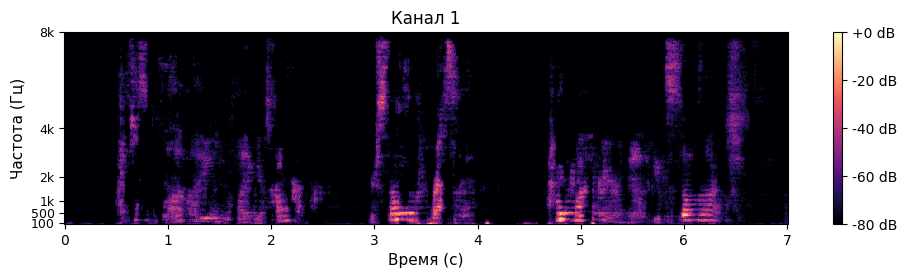

In [70]:
plot_audio_spectrogram(clean_est, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW)

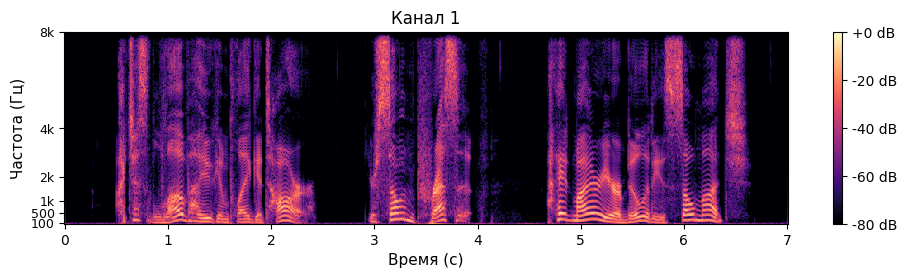

In [71]:
plot_audio_spectrogram(y_clean, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW)